In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

In [12]:
# DATA PREPROCESSING
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

from data_preprocessing import getData

schema, number_of_buildings, number_of_actions, random_seed = getData(
    active_actions=['electrical_storage', 'dhw_storage'],
    number_of_buildings=2,
    number_of_days=30,
    root_path="../../"
)

Active buildings in the schema: 
Building_1
Building_2


Active observations in the schema: 
day_type
hour
outdoor_dry_bulb_temperature
outdoor_dry_bulb_temperature_predicted_6h
outdoor_dry_bulb_temperature_predicted_12h
outdoor_dry_bulb_temperature_predicted_24h
outdoor_relative_humidity
outdoor_relative_humidity_predicted_6h
outdoor_relative_humidity_predicted_12h
outdoor_relative_humidity_predicted_24h
diffuse_solar_irradiance
diffuse_solar_irradiance_predicted_6h
diffuse_solar_irradiance_predicted_12h
diffuse_solar_irradiance_predicted_24h
direct_solar_irradiance
direct_solar_irradiance_predicted_6h
direct_solar_irradiance_predicted_12h
direct_solar_irradiance_predicted_24h
carbon_intensity
indoor_dry_bulb_temperature
indoor_relative_humidity
non_shiftable_load
solar_generation
dhw_storage_soc
electricity_pricing
cooling_device_cop
cooling_demand
dhw_demand
cooling_electricity_consumption
dhw_electricity_consumption
indoor_dry_bulb_temperature_delta


Active actions in the schema: 

In [9]:
from stable_baselines3.common.callbacks import BaseCallback
from citylearn.citylearn import CityLearnEnv

class CustomCallback(BaseCallback):
    def __init__(
        self,
        env: CityLearnEnv,
        trial,
        eval_freq: int = 10000,
        deterministic: bool = True,
    ):

        super().__init__(verbose=0)
        self.env = env
        self.reward_history = [0]
        self.last_mean_reward = 0
        self.learning_rates = []
        self.last_sum_reward = 0

        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False
        self.eval_freq = eval_freq
        self.n_calls = 0


        self.current_timestep = 0
    def _on_step(self) -> bool:
        if self.env.time_step == 0:
            self.reward_history.append(0)

        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])

        self.last_mean_reward = self.reward_history[-1] / (self.env.time_step + 1)
        self.last_sum_reward = self.reward_history[-1]
        self.n_calls += 1

        self.current_timestep += 1

        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need.
            if self.trial.should_prune():
                self.is_pruned = True
                return False

        return True

In [10]:
from typing import Any
from typing import Dict

import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
# from stable_baselines3 import SAC
from sbx import SAC
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
import torch
from citylearn.citylearn import CityLearnEnv
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
import flax.linen as nn
import numpy as np
from rewardFunctions.rewardFunction3 import CustomRewardFunction

N_TRIALS = 50
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 4
N_TIMESTEPS = 14400
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)


env = CityLearnEnv(schema, central_agent=True)

# set reward function
env.reward_function = CustomRewardFunction(env=env)

# wrap environment
env = NormalizedObservationWrapper(env)
env = StableBaselines3Wrapper(env)

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": env,
    "seed": random_seed
}


def sample_sac_params(trial: optuna.Trial) -> Dict[str, Any]:
    """Sampler for SAC hyperparameters."""
    gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
    learning_rate = trial.suggest_float("lr", 1e-5, 1, log=True)
    net_arch = trial.suggest_categorical("net_arch", ["tiny", "small"])
    activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])
    n_critics = trial.suggest_int("n_critics", 1, 5)
    batch_size = trial.suggest_int("batch_size", 64, 512)
    gradient_steps = trial.suggest_int("gradient_steps", 1, 20)
    policy_delay = trial.suggest_int("policy_delay", 1, 48)
    use_sde = trial.suggest_categorical("use_sde", [False, True])
    train_freq = trial.suggest_int("train_freq", 1, 24)
    tau =  trial.suggest_float("tau", 0.0001, 0.1, log=True)
    action_noise_sigma = trial.suggest_float("action_noise_sigma", 0.001, 0.3)
    action_noise = trial.suggest_categorical("action_noise", ["NormalActionNoise", "OrnsteinUhlenbeckActionNoise"])

    # Display true values.
    trial.set_user_attr("gamma_", gamma)

    net_arch = [
        256, 256 if net_arch == "tiny" else 512, 512
    ]
    
    n_actions = number_of_actions * number_of_buildings
    if (action_noise == "NormalActionNoise"):
        action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=action_noise_sigma * np.ones(n_actions))
    else:
        action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=action_noise_sigma * np.ones(n_actions))

    activation_fn = {"tanh": nn.tanh, "relu": nn.relu}[activation_fn]

    return {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "gradient_steps": gradient_steps,
        "policy_delay": policy_delay,
        "use_sde":use_sde,
        "train_freq": train_freq,
        "tau": tau,
        "action_noise": action_noise,
        "policy_kwargs": {
            "net_arch": net_arch,
            "activation_fn": activation_fn,
            "n_critics": n_critics
        },
    }


def objective(trial: optuna.Trial) -> float:
    kwargs = DEFAULT_HYPERPARAMS.copy()
    # Sample hyperparameters.
    kwargs.update(sample_sac_params(trial))
    # Create the RL model.
    model = SAC(**kwargs)

    eval_callback = CustomCallback(env, trial, eval_freq=EVAL_FREQ, deterministic=True)

    nan_encountered = False
    try:
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True
    finally:
        # Free memory.
        model.env.close()
        # eval_env.close()

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")
    
    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward


if __name__ == "__main__":
    # Set pytorch num threads to 1 for faster training.
    torch.set_num_threads(1)

    sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
    # Do not prune before 1/3 of the max budget is used.
    pruner = MedianPruner(n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_TIMESTEPS // 3)


    study_name = "SAC_tuning_2024-04-15-0"
    storage_name = "sqlite:///{}.db".format(study_name)
    study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize", study_name=study_name, storage=storage_name)
    try:
        study.optimize(objective, n_trials=N_TRIALS)
    except KeyboardInterrupt:
        pass

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    print("  User attrs:")
    for key, value in trial.user_attrs.items():
        print("    {}: {}".format(key, value))

[I 2024-04-15 00:25:28,203] A new study created in RDB with name: SAC_tuning_2024-04-15-0
[W 2024-04-15 01:02:51,560] Trial 0 failed with parameters: {'gamma': 0.0011035197731287909, 'lr': 0.0015956526373620131, 'net_arch': 'small', 'activation_fn': 'tanh', 'n_critics': 4, 'batch_size': 200, 'gradient_steps': 16, 'policy_delay': 48, 'use_sde': True, 'train_freq': 2, 'tau': 0.010182152866381092, 'action_noise_sigma': 0.01407662233584073, 'action_noise': 'OrnsteinUhlenbeckActionNoise'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Domonkos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Domonkos\AppData\Local\Temp\ipykernel_34300\3811786900.py", line 104, in objective
    model.learn(N_TIMESTEPS, callback=eval_callback)
  File "C:\Users\Domonkos\AppData\

Number of finished trials:  1
Best trial:


ValueError: Record does not exist.

## Study evaluation

In [1]:
import optuna

study_name = 'SAC_tuning_2024-04-18-0'

study = optuna.load_study(study_name='SAC_tuning_2024-04-18-0', storage=f"sqlite:///{study_name}.db")

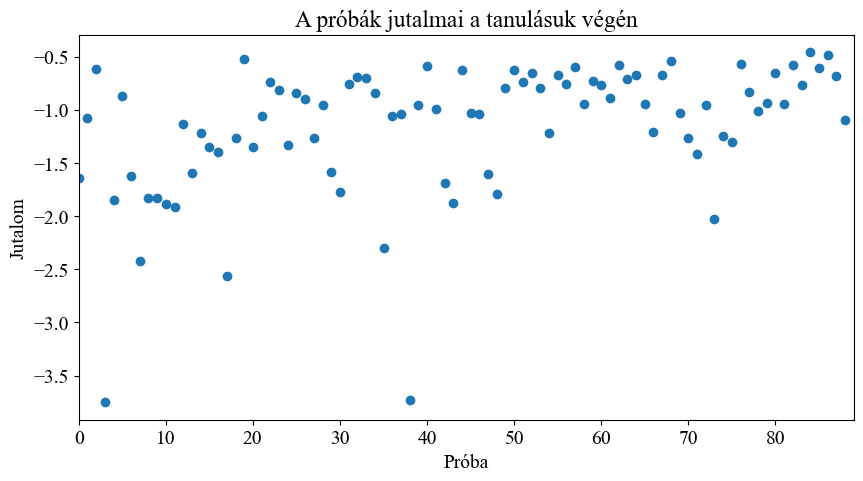

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14, 'font.family': 'Times New Roman'})

study_df = study.trials_dataframe()

plt.figure(figsize=(10, 5))
plt.scatter(study_df.index, study_df['value'])
plt.xlabel('Próba')
plt.ylabel('Jutalom')
plt.title('A próbák jutalmai a tanulásuk végén')
plt.xlim(0, 89)
plt.xticks(range(0, len(study_df), 10), range(0, len(study_df), 10))
plt.show()

In [3]:
study_df.sort_values(by='value', ascending=False, inplace=True)
study_df

,number,value,datetime_start,datetime_complete,duration,params_action_noise,params_action_noise_sigma,params_activation_fn,params_batch_size,params_gamma,params_gradient_steps,params_lr,params_n_critics,params_net_arch,params_policy_delay,params_tau,params_train_freq,params_use_sde,user_attrs_gamma_,state
84,85,-0.459416,2024-04-21 12:09:37.518054,2024-04-21 12:18:16.929538,0 days 00:08:39.411484,NormalActionNoise,0.020235,relu,212,0.043141,19,0.001029,5,small,9,0.003616,5,False,0.956859,COMPLETE
86,87,-0.487871,2024-04-21 12:27:21.243882,2024-04-21 12:36:31.656071,0 days 00:09:10.412189,NormalActionNoise,0.023584,relu,212,0.054577,19,0.001094,5,small,13,0.003878,6,False,0.945423,COMPLETE
19,19,-0.527403,2024-04-18 00:52:27.595326,2024-04-18 01:00:55.051592,0 days 00:08:27.456266,NormalActionNoise,0.105985,relu,273,0.008871,9,0.001191,4,small,5,0.001562,4,False,0.991129,COMPLETE
68,69,-0.544098,2024-04-20 13:10:15.970314,2024-04-20 13:21:49.358851,0 days 00:11:33.388537,OrnsteinUhlenbeckActionNoise,0.069365,relu,298,0.046018,20,0.000531,3,small,35,0.001494,2,False,0.953982,COMPLETE
76,77,-0.569366,2024-04-20 14:06:22.693032,2024-04-20 14:20:43.275077,0 days 00:14:20.582045,NormalActionNoise,0.081924,relu,245,0.030793,17,0.002292,5,tiny,9,0.001363,1,False,0.969207,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,35,-2.300829,2024-04-19 07:46:34.087988,2024-04-19 08:00:05.900075,0 days 00:13:31.812087,NormalActionNoise,0.244996,tanh,338,0.000109,8,0.001936,5,small,22,0.001076,1,False,0.999891,COMPLETE
7,7,-2.420382,2024-04-17 23:42:52.900834,2024-04-17 23:48:02.168914,0 days 00:05:09.268080,NormalActionNoise,0.165517,relu,115,0.003653,8,0.161187,1,small,12,0.000148,20,False,0.996347,COMPLETE
17,17,-2.563709,2024-04-18 00:41:24.806468,2024-04-18 00:46:51.956857,0 days 00:05:27.150389,NormalActionNoise,0.179731,relu,448,0.000942,1,0.208725,3,tiny,29,0.000256,9,False,0.999058,COMPLETE
38,38,-3.729491,2024-04-19 08:17:13.230730,2024-04-19 08:26:24.159327,0 days 00:09:10.928597,NormalActionNoise,0.229135,tanh,402,0.050347,11,0.005788,5,small,2,0.000983,3,False,0.949653,COMPLETE


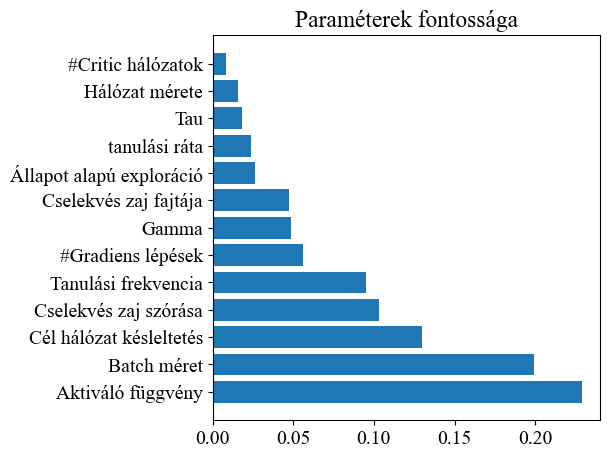

In [4]:
importances = optuna.importance.get_param_importances(study=study, evaluator=optuna.importance.FanovaImportanceEvaluator(n_trees=64, max_depth=64, seed=42))

translation = {
    'net_arch': 'Hálózat mérete',
    'tau': 'Tau',
    'n_critics': '#Critic hálózatok',
    'use_sde': 'Állapot alapú exploráció',
    'lr': 'tanulási ráta',
    'action_noise': 'Cselekvés zaj fajtája',
    'gradient_steps': '#Gradiens lépések',
    'gamma': 'Gamma',
    'policy_delay': 'Cél hálózat késleltetés',
    'train_freq': 'Tanulási frekvencia',
    'action_noise_sigma': 'Cselekvés zaj szórása',
    'batch_size': 'Batch méret',
    'activation_fn': 'Aktiváló függvény'
}

y_labels = [translation[key] for key in importances.keys()]

# create a plot of the importances
plt.figure(figsize=(5, 5))
plt.barh(range(len(importances)), importances.values(), align='center')
plt.yticks(range(len(importances)), y_labels)
plt.title('Paraméterek fontossága')
plt.show()

In [5]:
# find the best trial, where the activation_fn is tanh
best__tanh_trial = study_df.loc[study_df['params_activation_fn'] == 'tanh']
best__tanh_trial

,number,value,datetime_start,datetime_complete,duration,params_action_noise,params_action_noise_sigma,params_activation_fn,params_batch_size,params_gamma,params_gradient_steps,params_lr,params_n_critics,params_net_arch,params_policy_delay,params_tau,params_train_freq,params_use_sde,user_attrs_gamma_,state
58,59,-0.950810,2024-04-20 11:43:14.328061,2024-04-20 11:51:23.120358,0 days 00:08:08.792297,OrnsteinUhlenbeckActionNoise,0.040032,tanh,210,0.006641,20,0.001110,2,small,9,0.038997,6,False,0.993359,COMPLETE
88,89,-1.091904,2024-04-21 12:44:33.763972,2024-04-21 12:50:33.275462,0 days 00:05:59.511490,NormalActionNoise,0.016823,tanh,212,0.043365,17,0.000593,5,small,14,0.007464,8,False,0.956635,PRUNED
18,18,-1.264795,2024-04-18 00:46:51.984027,2024-04-18 00:52:27.568388,0 days 00:05:35.584361,OrnsteinUhlenbeckActionNoise,0.037555,tanh,364,0.002044,11,0.018253,1,tiny,12,0.014148,13,True,0.997956,COMPLETE
27,27,-1.265578,2024-04-18 01:56:23.787670,2024-04-18 02:05:28.125177,0 days 00:09:04.337507,OrnsteinUhlenbeckActionNoise,0.147732,tanh,157,0.001696,12,0.002237,3,small,19,0.001702,3,False,0.998304,COMPLETE
70,71,-1.267904,2024-04-20 13:28:19.841571,2024-04-20 13:35:45.483966,0 days 00:07:25.642395,OrnsteinUhlenbeckActionNoise,0.067775,tanh,265,0.080402,19,0.000504,3,small,27,0.000678,12,True,0.919598,COMPLETE
47,47,-1.604820,2024-04-19 09:27:59.378577,2024-04-19 09:33:48.876335,0 days 00:05:49.497758,OrnsteinUhlenbeckActionNoise,0.031535,tanh,145,0.004896,14,0.000791,5,small,25,0.000875,13,False,0.995104,COMPLETE
8,8,-1.825391,2024-04-17 23:48:02.196472,2024-04-17 23:54:35.525363,0 days 00:06:33.328891,OrnsteinUhlenbeckActionNoise,0.093900,tanh,405,0.000113,6,0.018109,5,tiny,1,0.021527,7,True,0.999887,COMPLETE
4,4,-1.844124,2024-04-17 23:24:51.482385,2024-04-17 23:31:14.441916,0 days 00:06:22.959531,NormalActionNoise,0.289461,tanh,169,0.000190,20,0.000025,5,small,24,0.000719,12,False,0.999810,COMPLETE
10,10,-1.890878,2024-04-18 00:01:21.428694,2024-04-18 00:09:55.731939,0 days 00:08:34.303245,OrnsteinUhlenbeckActionNoise,0.293432,tanh,385,0.031829,17,0.000014,4,tiny,15,0.000774,6,True,0.968171,COMPLETE
35,35,-2.300829,2024-04-19 07:46:34.087988,2024-04-19 08:00:05.900075,0 days 00:13:31.812087,NormalActionNoise,0.244996,tanh,338,0.000109,8,0.001936,5,small,22,0.001076,1,False,0.999891,COMPLETE


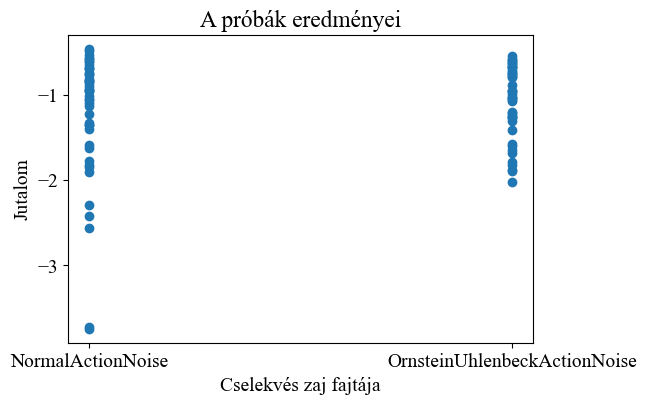

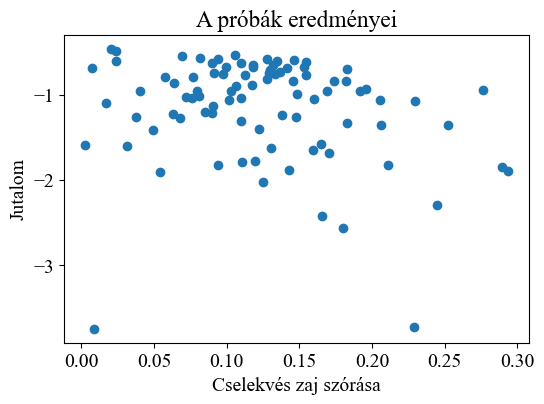

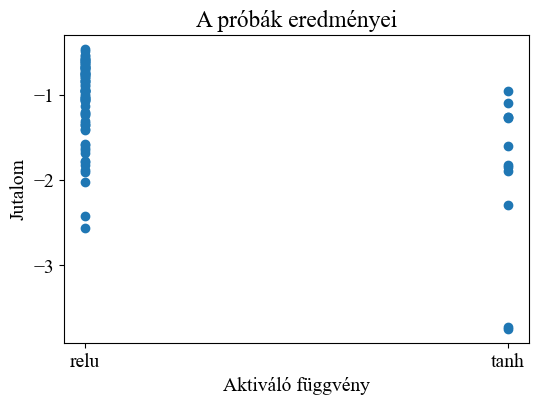

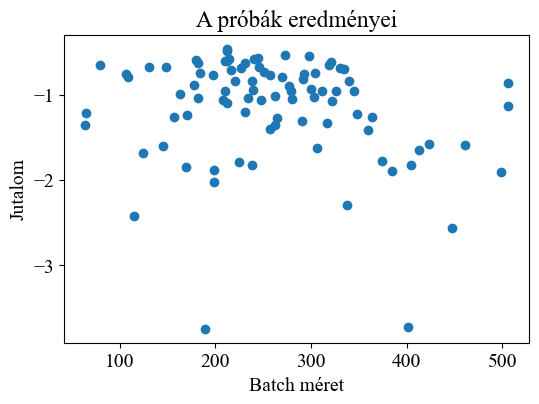

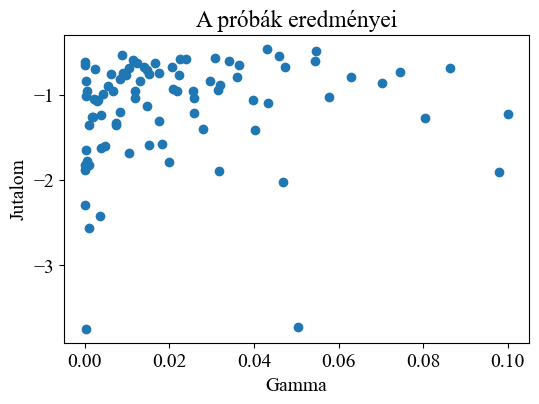

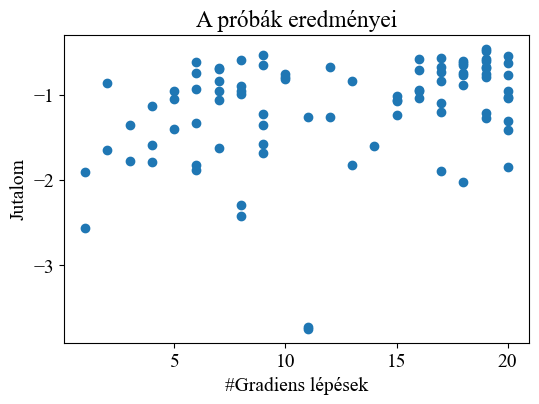

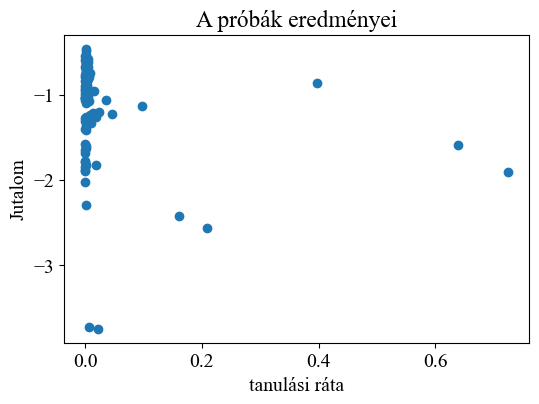

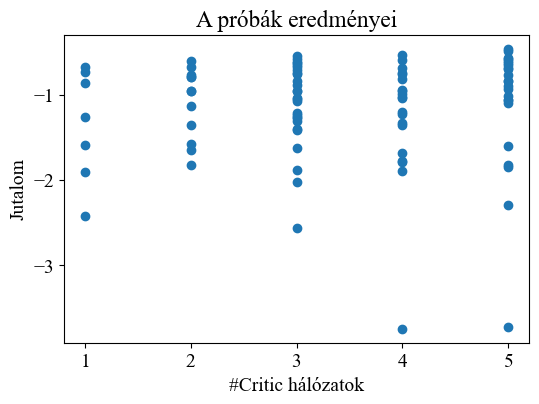

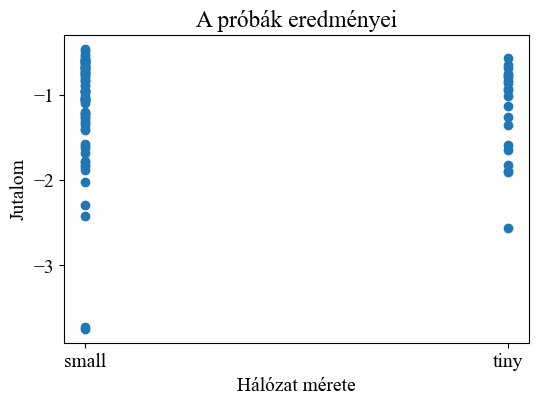

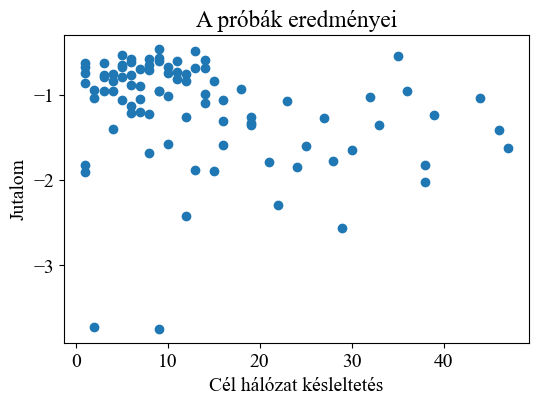

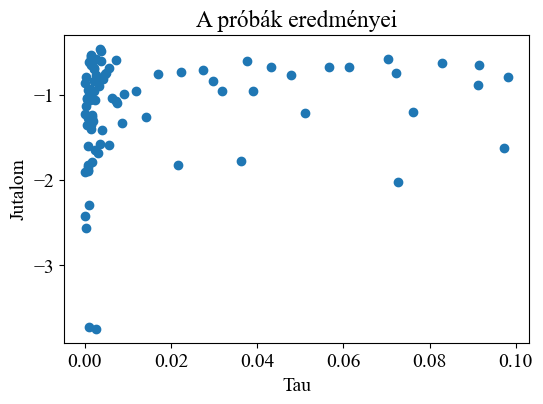

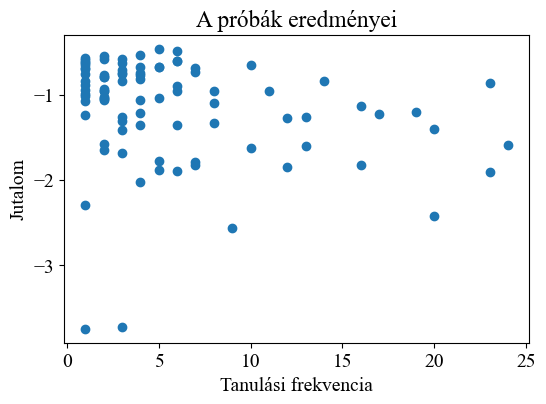

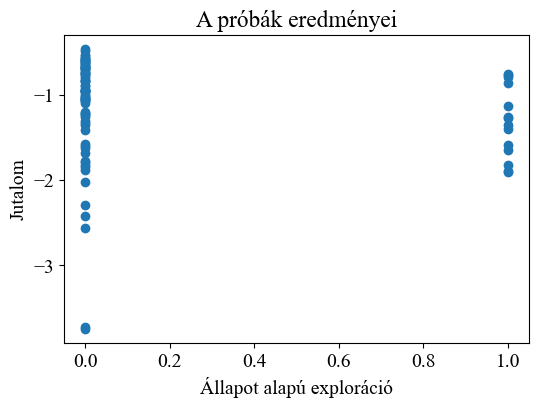

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression



# study_df = study_df.loc[(study_df['params_action_noise_sigma'] > 0.05) & (study_df['params_action_noise_sigma'] < 0.16)]
# study_df = study_df.loc[(study_df['value'] > -1)]

log_param_list = ['params_lr', 'params_gamma', 'params_tau']

def logistic_function(x, a, b):
    return 1 / (1 + np.exp(-a*(x-b)))

for column in study_df.columns:
    if column.startswith("params_"):
        param_df = study_df[study_df[column].notna()][[column, "value"]]
        aggregated_df = param_df.groupby(column).mean().sort_values(column, ascending=False)

        plt.figure(figsize=(6, 4))
        plt.scatter(param_df[column], param_df["value"])
        # if column in log_param_list:
        #     plt.xscale("log")

        #     X = np.log(param_df[column]).values.reshape(-1, 1)
        #     y = param_df['value'].values
        #     model = LinearRegression().fit(X, y)

        #     plt.plot(param_df[column], model.predict(X), color='red')

        # elif param_df[column].dtype == 'float64' or param_df[column].dtype == 'int64':
        #     X = param_df[column].values.reshape(-1, 1)
        #     y = param_df['value'].values
        #     model = LinearRegression().fit(X, y)

        #     plt.plot(param_df[column], model.predict(X), color='red')

        plt.xlabel(translation[column.replace('params_', '')])
        plt.ylabel('Jutalom')
        plt.title("A próbák eredményei")
        plt.show()